In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
import re
from dotenv import load_dotenv
import os
from tqdm import tqdm
from groq import Groq
import torch.nn.functional as F
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

load_dotenv()

c:\Users\Rajeev Wankar\Desktop\Aarsh IITGN\Semester_5\STT-CSE\LAB_2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
token_limit = 6000

In [3]:
master_df = pd.read_csv('files_df.csv')
print(len(master_df))
master_df["diff"] = master_df["diff"].fillna("")

1247


In [4]:
print(master_df.columns)

Index(['hash', 'date', 'original_message', 'file_name', 'prev_source_code',
       'cur_source_code', 'diff', 'llm_commit_inference', 'rectified_message'],
      dtype='object')


In [5]:
sim_tokenizer = AutoTokenizer.from_pretrained("microsoft/unixcoder-base")
sim_model = AutoModel.from_pretrained("microsoft/unixcoder-base")
llama_tokenizer = AutoTokenizer.from_pretrained('meta-llama/Meta-Llama-3.1-8B-Instruct')

In [6]:

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
    sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)
    return sum_embeddings / sum_mask

def get_embedding(text):
    inputs = sim_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    outputs = sim_model(**inputs)
    embeddings = mean_pooling(outputs, inputs['attention_mask'])
    embeddings = F.normalize(embeddings, p=2, dim=1)  # Normalize for cosine similarity
    return embeddings

def find_similarity(diff, pred):
    emb_diff = get_embedding(diff)
    emb_pred = get_embedding(pred)
    similarity = torch.cosine_similarity(emb_diff, emb_pred)
    return similarity.item()

def get_prompt_for_rectification(diff, original_commit_msg, new_commit_msg):
    return f"""
You are a helpful assistant for refining commit messages at the file level.
Here is the context:
Original Commit Message:
"{original_commit_msg}"

Generated File-Level Message:
"{new_commit_msg}"

File Diff:
{diff}

Your task is to improve the file-level message so it:
- Aligns with the intent of the original commit message
- Accurately describes the changes in the diff along with function/method names
- Is clear, concise, and grammatically correct
Please provide the refined message without any additional commentary or explanation.
Do not include explanations or formatting.
Refined Message:
"""

def prompt_groq_api(prompt_text):
    groq_key = os.getenv("GROQ_API_KEY")
    client = Groq(api_key=groq_key)

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant for refining commit messages at the file level."
            },
            {
                "role": "user",
                "content": prompt_text,
            }
        ],

        model = "llama-3.1-8b-instant",
        max_tokens=100,
        temperature=0.0,
        top_p=1.0
    )
    return chat_completion.choices[0].message.content

def preprocess_custom_diff(diff_text):
    lines = diff_text.split('\n')
    added_code_lines = [line[len('<add>'):].strip() for line in lines if line.startswith('<add>')]
    return '\n'.join(added_code_lines)

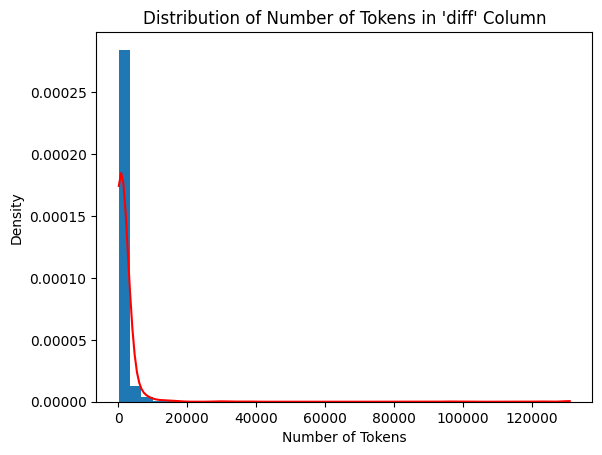

In [7]:
n_tokens = [len(llama_tokenizer(get_prompt_for_rectification(row["diff"], row["original_message"], row["llm_commit_inference"]), return_tensors="pt", truncation=True)[0]) for _, row in master_df.iterrows()]

plt.hist(n_tokens, bins=40, density=True)
plt.xlabel("Number of Tokens")
plt.ylabel("Density")
plt.title("Distribution of Number of Tokens in 'diff' Column")

# Overlay a KDE for a smoother curve
kde = gaussian_kde(n_tokens)
x_vals = np.linspace(min(n_tokens), max(n_tokens), 200)
plt.plot(x_vals, kde(x_vals), color='red')

plt.show()

In [ ]:
filtered_df = master_df[master_df.apply(
    lambda row: len(llama_tokenizer(get_prompt_for_rectification(row["diff"], row["original_message"], row["llm_commit_inference"]),
    return_tensors='pt')[0]) < token_limit,
    axis=1)]
print(len(filtered_df))

Token indices sequence length is longer than the specified maximum sequence length for this model (193351 > 131072). Running this sequence through the model will result in indexing errors


1208


In [9]:
sample_df = filtered_df.sample(n=200, random_state=42)

In [10]:
failed_rectifications = []

In [11]:
from tqdm import tqdm
import time

for i, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    diff = row["diff"]
    commit_message = row["original_message"]
    llm_message = row["llm_commit_inference"]
    # Retry logic for 403 errors (rate limit)
    max_retries = 5
    retry_delay = 12  # seconds, since 6000 tokens/min = 100 tokens/sec, so 12s is conservative

    for attempt in range(max_retries):
        try:
            rectified_message = prompt_groq_api(get_prompt_for_rectification(diff, commit_message, llm_message))
            break
        except Exception as e:
            if hasattr(e, 'status_code') and e.status_code == 403:
                print(f"Rate limit hit (403). Sleeping for {retry_delay} seconds before retrying...")
                time.sleep(retry_delay)
            else:
                print(f"Error: {e}")
                rectified_message = ""
                failed_rectifications.append(i)
                break
    else:
        rectified_message = ""
        failed_rectifications.append(i)

    sample_df.at[i, "rectified_message"] = rectified_message
    sample_df.to_csv('rectified_sample_df.csv', index=False)

  0%|          | 0/200 [00:00<?, ?it/s]C:\Users\Rajeev Wankar\AppData\Local\Temp\ipykernel_14328\2333417380.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'update laptop.py to remove unnecessary screen_plate variable and correct keyboard positioning' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  sample_df.at[i, "rectified_message"] = rectified_message
100%|██████████| 200/200 [36:01<00:00, 10.81s/it] 


In [12]:
print(len(failed_rectifications))

0


In [13]:
# Finding the scores
for i, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    diff = row["diff"]
    og_commit = row["original_message"]
    llm_commit = row["llm_commit_inference"]
    rect_commit = row["rectified_message"]
    og_score = find_similarity(diff, og_commit)
    llm_score = find_similarity(diff, llm_commit)
    rectified_score = find_similarity(diff, rect_commit)
    sample_df.at[i, "og_score"] = og_score
    sample_df.at[i, "llm_score"] = llm_score
    sample_df.at[i, "rectified_score"] = rectified_score

sample_df.to_csv('rectified_sample_df.csv', index=False)

100%|██████████| 200/200 [08:16<00:00,  2.48s/it]


In [14]:
# Analyzing the hitrate
mean_og_score = sample_df["og_score"].mean()
mean_llm_score = sample_df["llm_score"].mean()
mean_rectified_score = sample_df["rectified_score"].mean()

print("Mean Original Score:", mean_og_score)
print("Mean LLM Score:", mean_llm_score)
print("Mean Rectified Score:", mean_rectified_score)

Mean Original Score: 0.35488090026658026
Mean LLM Score: 0.2715635695680976
Mean Rectified Score: 0.41766484186053277


In [17]:
# Sorting the sample_df by date
sample_df = sample_df.sort_values(by='date')

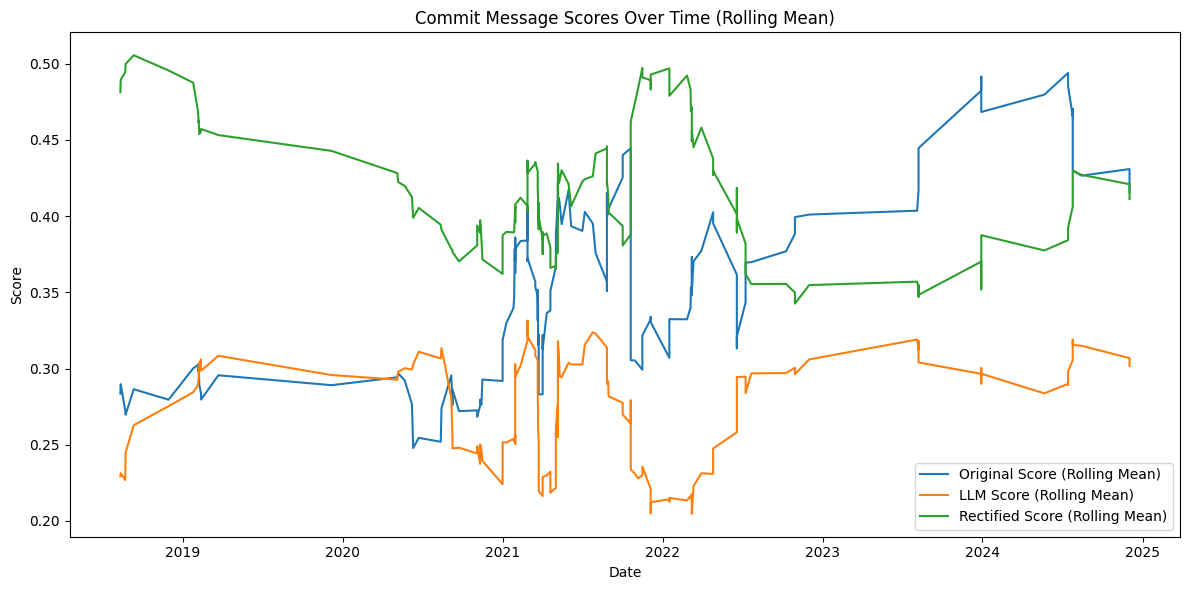

In [23]:
# Ensure 'date' is datetime and set as index if not already
if sample_df.index.name != 'date':
    sample_df['date'] = pd.to_datetime(sample_df['date'])
    sample_df = sample_df.sort_values('date').set_index('date')

# Calculate rolling mean (window=10, adjust as needed)
window = 20
rolling_og = sample_df['og_score'].rolling(window).mean()
rolling_llm = sample_df['llm_score'].rolling(window).mean()
rolling_rect = sample_df['rectified_score'].rolling(window).mean()

plt.figure(figsize=(12, 6))
plt.plot(rolling_og, label='Original Score (Rolling Mean)')
plt.plot(rolling_llm, label='LLM Score (Rolling Mean)')
plt.plot(rolling_rect, label='Rectified Score (Rolling Mean)')
plt.xlabel('Date')
plt.ylabel('Score')
plt.title('Commit Message Scores Over Time (Rolling Mean)')
plt.legend()
plt.tight_layout()
plt.show()
